In [86]:
import pandas as pd
import os

# Folder containing the CSV files
folder_path = "."

# List of CSV filenames
file_names = [
    "d23_regions_filled.csv", "d22_regions_filled.csv", "d21_regions_filled.csv", "d20_regions_filled.csv", "d19_regions_filled.csv", 
    "d18_regions_filled.csv", "d17_regions_filled.csv", "d16_regions_filled.csv"
]

# Dictionary to store loaded DataFrames
dfs = {}

# Read each CSV file into a DataFrame
for file in file_names:
    file_path = os.path.join(folder_path, file)
    df_name = file.replace("_regions_filled.csv", "")
    dfs[df_name] = pd.read_csv(file_path)

# Display the keys (i.e., DataFrame names)
print("Loaded DataFrames:")
print(list(dfs.keys()))


Loaded DataFrames:
['d23', 'd22', 'd21', 'd20', 'd19', 'd18', 'd17', 'd16']


In [87]:
combined_df = pd.concat([dfs[name] for name in dfs], ignore_index=True)
dfs['d23']['REGION'].unique()

array(['East Midlands', 'East of England', 'London', 'North East',
       'North West', 'South East', 'South West', 'Wales', 'West Midlands',
       'Yorkshire and The Humber', nan], dtype=object)

In [88]:
import numpy as np
import pandas as pd

# Standardize column names
combined_df.columns = combined_df.columns.str.strip().str.lower()
combined_df["substance name"] = combined_df["substance name"].astype(str).str.lower()

# Filter for Indeno(1,2,3-cd)pyrene
target_df = combined_df[combined_df["substance name"] == "indeno(1,2,3-cd)pyrene"].copy()

# Clean numeric fields
target_df["quantity released (kg)"] = pd.to_numeric(target_df["quantity released (kg)"], errors='coerce')
target_df["reporting threshold (kg)"] = pd.to_numeric(target_df["reporting threshold (kg)"], errors='coerce')

# Drop NaNs
qty = target_df["quantity released (kg)"].dropna()
threshold = target_df["reporting threshold (kg)"].mean()

# Summary stats
summary = {
    "Mean": qty.mean(),
    "Std Dev": qty.std(),
    "Min": qty.min(),
    "Max": qty.max(),
    "5th Percentile": np.percentile(qty, 5),
    "10th Percentile": np.percentile(qty, 10),
    "25th Percentile": np.percentile(qty, 25),
    "50th Percentile (Median)": np.percentile(qty, 50),
    "75th Percentile": np.percentile(qty, 75),
    "90th Percentile": np.percentile(qty, 90),
    "95th Percentile": np.percentile(qty, 95),
    "Reporting Threshold (mean)": threshold,
    "Nb of Obs": len(qty),
    "Nb Below Threshold": (qty < threshold).sum(),
    "Nb of Different Sites": target_df["site address"].nunique()
}

# Mean number of years per site
target_df["year"] = target_df["authorisation id / permit id"].str.extract(r'(\d{2})').astype(float) + 2000
mean_years_per_site = target_df.groupby("site address")["year"].nunique().mean()

# Share of obs from urban areas
urban_share = (target_df["region"].str.lower() == "urban").mean()

# Share of samples by region
regions = [
    "north east", "north west", "yorkshire and the humber", "east midlands",
    "west midlands", "east of england", "london", "south east", "south west",
]
region_shares = {region.title(): (target_df["region"].str.lower() == region).mean() for region in regions}

# Share of samples by year
years = list(range(2015, 2024))
year_shares = {str(year): (target_df["year"] == year).mean() for year in years}

# Share of samples from wastewater companies
wastewater_keywords = ["water", "wastewater", "sewerage"]
target_df["is_wastewater"] = target_df["operator name"].str.lower().apply(
    lambda x: any(word in x for word in wastewater_keywords)
)
wastewater_share = target_df["is_wastewater"].mean()

# Print results
for k, v in summary.items():
    print(f"{k}: {v:.4f}" if isinstance(v, (int, float)) else f"{k}: {v}")
print(f"Mean number of years per site: {mean_years_per_site:.2f}")
print(f"Share from urban areas: {urban_share:.2%}")
print("\n--- Region Shares ---")
for k, v in region_shares.items():
    print(f"{k}: {v:.2%}")
print("\n--- Year Shares ---")
for k, v in year_shares.items():
    print(f"{k}: {v:.2%}")
print(f"\nShare of wastewater company samples: {wastewater_share:.2%}")


Mean: 1.0462
Std Dev: 2.4853
Min: 0.0000
Max: 23.5000
5th Percentile: 0.0000
10th Percentile: 0.0000
25th Percentile: 0.0000
50th Percentile (Median): 0.0000
75th Percentile: 1.2800
90th Percentile: 2.5478
95th Percentile: 4.6240
Reporting Threshold (mean): 1.0000
Nb of Obs: 1109.0000
Nb Below Threshold: 716
Nb of Different Sites: 224.0000
Mean number of years per site: 1.01
Share from urban areas: 0.00%

--- Region Shares ---
North East: 6.67%
North West: 20.29%
Yorkshire And The Humber: 9.92%
East Midlands: 7.48%
West Midlands: 11.45%
East Of England: 12.62%
London: 5.14%
South East: 17.49%
South West: 7.84%

--- Year Shares ---
2015: 0.18%
2016: 10.28%
2017: 6.31%
2018: 0.00%
2019: 0.00%
2020: 3.43%
2021: 0.36%
2022: 0.72%
2023: 0.72%

Share of wastewater company samples: 78.54%


In [89]:
# Step 3: Clean quantity column
combined_df["quantity released (kg)"] = pd.to_numeric(
    combined_df["quantity released (kg)"], errors='coerce'
).fillna(0)

# Step 4: Filter only Indeno(1,2,3-cd)pyrene
combined_target = combined_df[combined_df["substance name"] == "indeno(1,2,3-cd)pyrene"]

# Step 5: Compute total weight across all years
total_weight = combined_target["quantity released (kg)"].sum()

# Step 6: Compute share per year (d23 to d16)
year_shares = {}

for year in ['d23', 'd22', 'd21', 'd20', 'd19', 'd18', 'd17', 'd16']:
    df = dfs[year].copy()
    df.columns = df.columns.str.strip().str.lower()
    df["quantity released (kg)"] = pd.to_numeric(df["quantity released (kg)"], errors='coerce').fillna(0)
    
    year_weight = df[df["substance name"] == "indeno(1,2,3-cd)pyrene"]["quantity released (kg)"].sum()
    year_shares[year] = year_weight / total_weight if total_weight > 0 else 0

# Step 7: Print the result
print("Share of Indeno(1,2,3-cd)pyrene’s total weight by year:")
for year, share in year_shares.items():
    print(f"{year}: {share:.2%}")


Share of Indeno(1,2,3-cd)pyrene’s total weight by year:
d23: 0.00%
d22: 0.00%
d21: 0.00%
d20: 0.00%
d19: 0.00%
d18: 0.00%
d17: 0.00%
d16: 0.00%


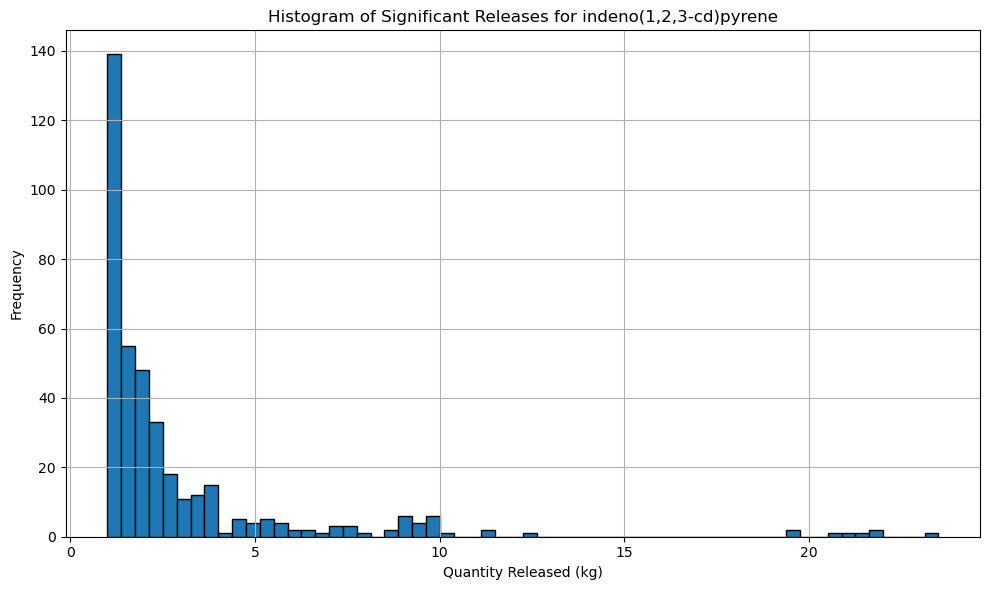

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure column names are clean and lowercase
combined_df.columns = combined_df.columns.str.strip().str.lower()

# Filter for the target substance (adjust name as needed)
target_substance = "indeno(1,2,3-cd)pyrene"
target_df = combined_df[combined_df["substance name"].str.lower() == target_substance].copy()

# Clean numeric fields
target_df["quantity released (kg)"] = pd.to_numeric(target_df["quantity released (kg)"], errors="coerce")
target_df["reporting threshold (kg)"] = pd.to_numeric(target_df["reporting threshold (kg)"], errors="coerce")

# Keep only values ABOVE the reporting threshold
significant_df = target_df[
    target_df["quantity released (kg)"] > target_df["reporting threshold (kg)"]
].dropna(subset=["quantity released (kg)"])

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(significant_df["quantity released (kg)"], bins=60, edgecolor='black')
plt.title(f"Histogram of Significant Releases for {target_substance}")
plt.xlabel("Quantity Released (kg)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


In [91]:
for year_str in ['d16', 'd17', 'd18', 'd19', 'd20', 'd21', 'd22', 'd23']:
    dfs[year_str]['year'] = int('20' + year_str[1:])  # e.g. 'd16' → 2016
combined_df = pd.concat(dfs.values(), ignore_index=True)

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Standardize
combined_df.columns = combined_df.columns.str.strip().str.lower()
combined_df["substance name"] = combined_df["substance name"].astype(str).str.lower()

# Filter
target_df = combined_df[combined_df["substance name"] == "indeno(1,2,3-cd)pyrene"].copy()
target_df["quantity released (kg)"] = pd.to_numeric(target_df["quantity released (kg)"], errors='coerce')
target_df["reporting threshold (kg)"] = pd.to_numeric(target_df["reporting threshold (kg)"], errors='coerce')
threshold = target_df["reporting threshold (kg)"].mean()

# Filter significant
significant_df = target_df[target_df["quantity released (kg)"] > threshold]



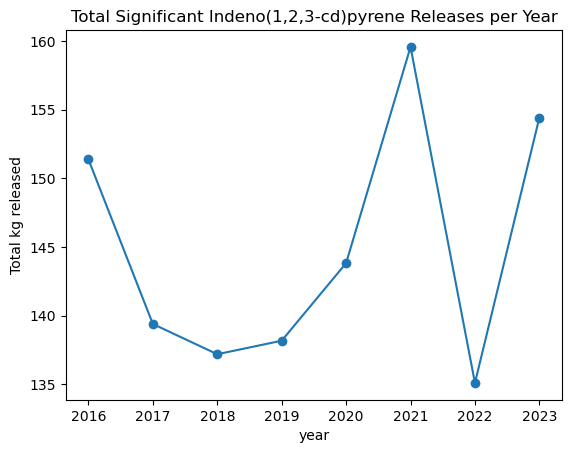

In [93]:
yearly_sum = significant_df.groupby("year")["quantity released (kg)"].sum()
yearly_sum.plot(marker='o', title="Total Significant Indeno(1,2,3-cd)pyrene Releases per Year")
plt.ylabel("Total kg released")
plt.show()



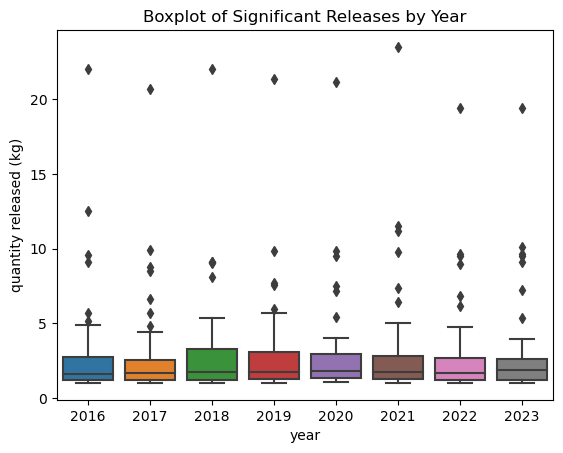

In [94]:
sns.boxplot(data=significant_df, x="year", y="quantity released (kg)")
plt.title("Boxplot of Significant Releases by Year")
plt.show()


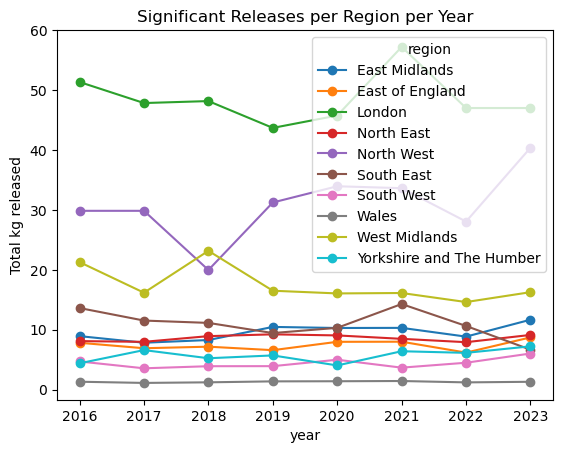

In [95]:
pivot = significant_df.pivot_table(index="year", columns="region", values="quantity released (kg)", aggfunc="sum")
pivot.plot(title="Significant Releases per Region per Year", marker='o')
plt.ylabel("Total kg released")
plt.show()


In [96]:
# Ensure 'operator name' and 'year' columns are clean
target_df["operator name"] = target_df["operator name"].astype(str).str.strip().str.lower()

# Unique companies per year
companies_by_year = target_df.groupby("year")["operator name"].nunique()
print("Unique companies per year:\n", companies_by_year)


Unique companies per year:
 year
2016    26
2017    23
2018    29
2019    35
2020    36
2021    37
2022    36
2023    35
Name: operator name, dtype: int64


In [97]:
# Build a dict of sets of companies by year
companies_sets = {
    year: set(target_df[target_df["year"] == year]["operator name"].unique())
    for year in target_df["year"].unique()
}

# Example: Find companies that appear every year
years = sorted(companies_sets.keys())
common_companies = set.intersection(*(companies_sets[year] for year in years))

print(f"Companies reporting in all years ({len(common_companies)}):")
for company in common_companies:
    print("-", company)

overlap_counts = {}

for i in range(1, len(years)):
    year_a = years[i - 1]
    year_b = years[i]
    overlap = companies_sets[year_a].intersection(companies_sets[year_b])
    overlap_counts[f"{year_a}-{year_b}"] = len(overlap)

print("\nCompany overlaps between consecutive years:")
for k, v in overlap_counts.items():
    print(f"{k}: {v} companies")

# Filter for non-zero emissions
nonzero_df = target_df[target_df["quantity released (kg)"] > 0]

# Count distinct operator names
num_companies = nonzero_df["operator name"].nunique()

print(f"Number of companies with significant emissions: {num_companies}")


Companies reporting in all years (9):
- northumbrian water ltd
- anglian water
- thames water utilities ltd
- wessex water
- phillips 66 limited
- 3c waste limited
- severn trent water ltd
- south west water ltd
- united utilities water plc

Company overlaps between consecutive years:
2016-2017: 19 companies
2017-2018: 20 companies
2018-2019: 22 companies
2019-2020: 29 companies
2020-2021: 31 companies
2021-2022: 28 companies
2022-2023: 24 companies
Number of companies with significant emissions: 14


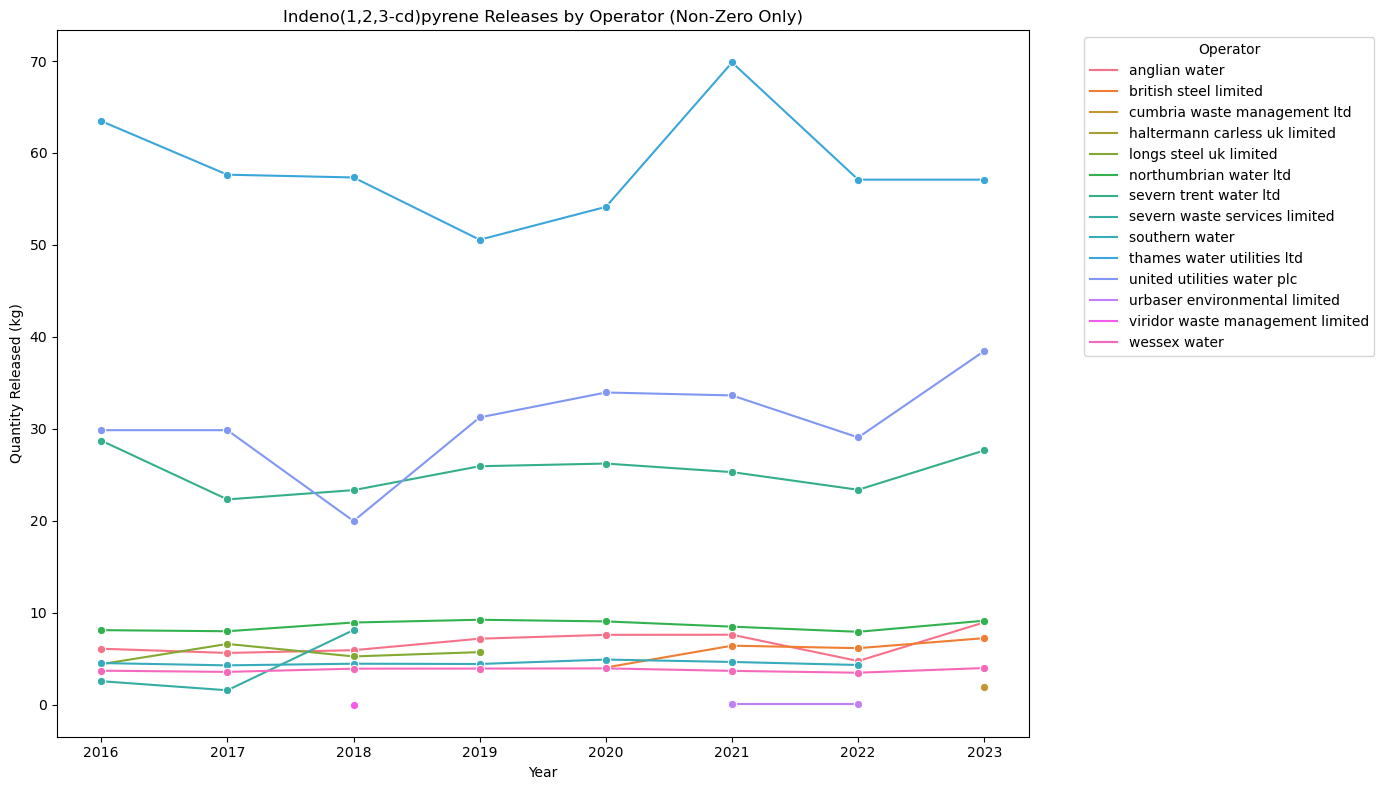

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for non-zero quantity released
nonzero_df = target_df[target_df["quantity released (kg)"] > 0]

# Group by operator and year, summing the quantities
company_trends = (
    nonzero_df.groupby(["operator name", "year"])["quantity released (kg)"]
    .sum()
    .reset_index()
)

# Plot the trends
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=company_trends,
    x="year",
    y="quantity released (kg)",
    hue="operator name",
    marker="o"
)
plt.title("Indeno(1,2,3-cd)pyrene Releases by Operator (Non-Zero Only)")
plt.xlabel("Year")
plt.ylabel("Quantity Released (kg)")
plt.legend(title="Operator", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [107]:
# # Extract unique non-zero-emission companies
# unique_companies = (
#     target_df[target_df["quantity released (kg)"] > 0]["operator name"]
#     .dropna()
#     .drop_duplicates()
#     .reset_index(drop=True)
# )

# # Convert Series to proper DataFrame with column name
# company_column_df = pd.DataFrame({"OPERATOR NAME": unique_companies})

# # Save to CSV
# company_column_df.to_csv("company_data.csv", index=False)

# print("Saved 14 unique companies to 'company_data.csv'")



Saved 14 unique companies to 'company_data.csv'
